# İş Problemi

📌 Kişilerin özellikleri belirlendiğinde diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenme modelinin geliştirilmesi istenmektedir. Modeli geliştirmeden önce gerekli veri analizi ve özellik mühendisliği adımlarını gerçekleştirmeniz beklenmektedir.

# Veri Seti Hikayesi

📌 Veri seti, ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan geniş veri setinin bir parçasıdır. ABD'nin Arizona Eyaleti'nin 5. büyük şehri Phoenix'te yaşayan 21 yaş ve üzeri Pima Hintli kadınlara ilişkin diyabet araştırmalarında kullanılan veriler. Hedef değişken "outcome" olarak belirtilir; 1 pozitif diyabet testi sonucunu, 0 ise negatifi gösterir.

Pregnancies: Gebelik sayısı

Glucose: Oral glukoz tolerans testinde 2 saatlik plazma glukoz konsantrasyonu

Blood Pressure: Kan Basıncı (Küçük tansiyon) (mm Hg)

SkinThickness:  Cilt Kalınlığı

Insulin:  2 saatlik serum insülini (mu U/ml)

DiabetesPedigreeFunction:  Fonksiyon (oral glukoz tolerans testinde 2 saatlik plazma glukoz konsantrasyonu)

BMI: vücut kitle indeksi

Age: Yaş (yıl)

Outcome: Hastalığa sahip olmak (1) veya olmamak (0)

# Gerekli Kütüphanelerin import Edilmesi

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

# Veri setinin okutulması

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6000,0.6270,50,1
1,1,85,66,29,0,26.6000,0.3510,31,0
2,8,183,64,0,0,23.3000,0.6720,32,1
3,1,89,66,23,94,28.1000,0.1670,21,0
4,0,137,40,35,168,43.1000,2.2880,33,1


# Veri setinden genel bilgileri çıkartmak

In [4]:
def check_df(dataframe,head=5):
  print(20*"#", "Head", 20*"#")
  print(dataframe.head(head))
  print(20*"#", "Tail", 20*"#")
  print(dataframe.tail(head))
  print(20*"#", "Shape", 20*"#")
  print(dataframe.shape)
  print(20*"#", "Types", 20*"#")
  print(dataframe.dtypes)
  print(20*"#", "NA", 20*"#")
  print(dataframe.isnull().sum())
  print(20*"#", "Qurtiles", 20*"#")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [6]:
check_df(df)

#################### Head ####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72             35        0 33.6000                    0.6270   50        1
1            1       85             66             29        0 26.6000                    0.3510   31        0
2            8      183             64              0        0 23.3000                    0.6720   32        1
3            1       89             66             23       94 28.1000                    0.1670   21        0
4            0      137             40             35      168 43.1000                    2.2880   33        1
#################### Tail ####################
     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction  Age  Outcome
763           10      101             76             48      180 32.9000                    0.1710   63        0
764           

# Kategorik ve sayısal değişkenler üzerinde analiz yapmak

In [8]:
def grab_cols_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "bool", "object"]]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and str(dataframe[col].dtypes) in ["uint8", "int64", "float64"]]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and str(df[col].dtypes) in ["category", "object"]]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["uint8", "int64", "float64"]]
  num_cols = [col for col in num_cols if col not in cat_cols]

  return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols, num_cols, cat_but_car, num_but_cat = grab_cols_names(df)
print(f"Observation: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")
print(f"Cat Cols: {len(cat_cols)}")
print(f"Num Cols: {len(num_cols)}")
print(f"Cat But Car: {len(cat_but_car)}")
print(f"Num But Cat: {len(num_but_cat)}")

Observation: 768
Variables: 9
Cat Cols: 1
Num Cols: 8
Cat But Car: 0
Num But Cat: 1


In [9]:
def cat_summary(dataframe, col_name, plot=False):
  print(f"################### {col_name} ###################")
  print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                      "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe) }))

  if plot:
    sns.countplot(x = dataframe[col_name], data=dataframe)
    plt.show()

In [10]:
def cat_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_cols_names(dataframe)
  for col in cat_cols:
    if str(dataframe[col].dtypes) == "bool":
      new_df = pd.DataFrame()
      new_df[col] = dataframe[col].astype(int)
      cat_summary(new_df, col, plot=True)
    else:
      cat_summary(dataframe, col, plot=True)

################### Outcome ###################
   Outcome   Ratio
0      500 65.1042
1      268 34.8958


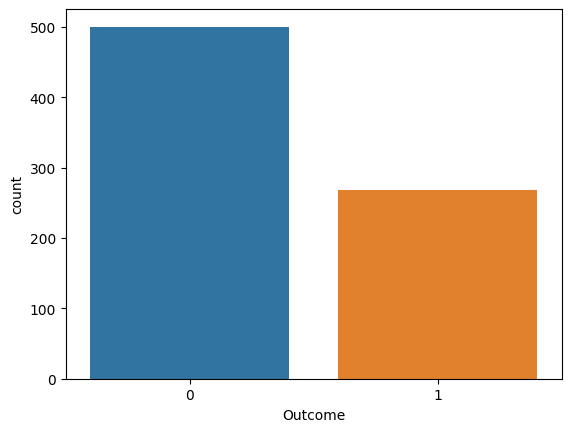

In [11]:
cat_summary_df(df)

In [12]:
def num_summary(dataframe, num_col, plot=False):
  print(f"################### {num_col} ###################")
  quantiles = [0.01, 0.05, 0.10, 0.20, 0.30 ,0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1]
  print(dataframe[num_col].describe(quantiles).T)

  if plot:
    dataframe[num_col].hist(bins=20)
    plt.xlabel(num_col)
    plt.ylabel(num_col)
    plt.show()

In [13]:
def num_summary_df(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_cols_names(dataframe)
  for col in num_cols:
    num_summary(dataframe, col, plot=True)

################### Pregnancies ###################
count   768.0000
mean      3.8451
std       3.3696
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       1.0000
30%       1.0000
40%       2.0000
50%       3.0000
60%       4.0000
70%       5.0000
80%       7.0000
90%       9.0000
95%      10.0000
99%      13.0000
100%     17.0000
max      17.0000
Name: Pregnancies, dtype: float64


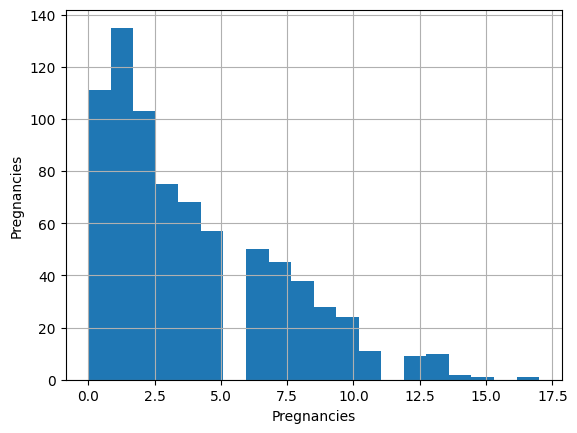

################### Glucose ###################
count   768.0000
mean    120.8945
std      31.9726
min       0.0000
1%       57.0000
5%       79.0000
10%      85.0000
20%      95.0000
30%     102.0000
40%     109.0000
50%     117.0000
60%     125.0000
70%     134.0000
80%     147.0000
90%     167.0000
95%     181.0000
99%     196.0000
100%    199.0000
max     199.0000
Name: Glucose, dtype: float64


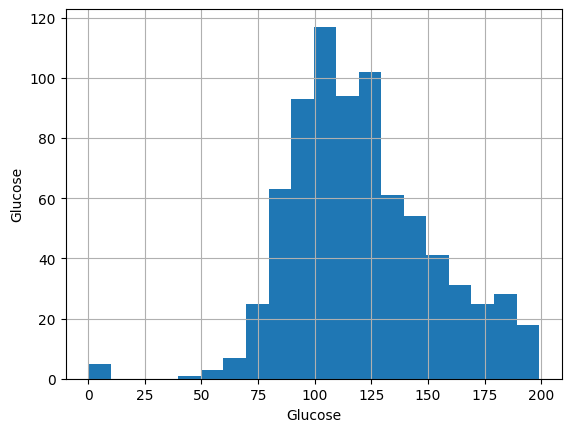

################### BloodPressure ###################
count   768.0000
mean     69.1055
std      19.3558
min       0.0000
1%        0.0000
5%       38.7000
10%      54.0000
20%      60.0000
30%      64.0000
40%      68.0000
50%      72.0000
60%      74.0000
70%      78.0000
80%      82.0000
90%      88.0000
95%      90.0000
99%     106.0000
100%    122.0000
max     122.0000
Name: BloodPressure, dtype: float64


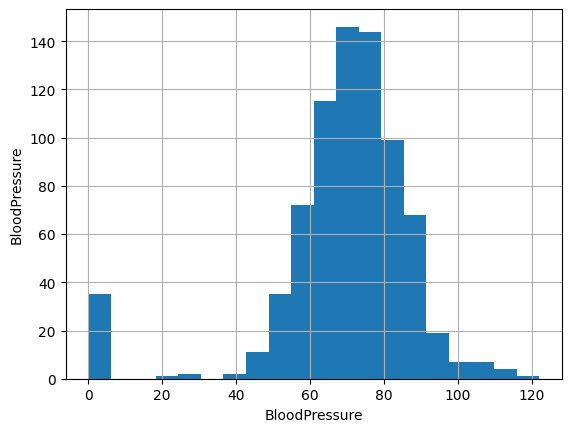

################### SkinThickness ###################
count   768.0000
mean     20.5365
std      15.9522
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       8.2000
40%      18.0000
50%      23.0000
60%      27.0000
70%      31.0000
80%      35.0000
90%      40.0000
95%      44.0000
99%      51.3300
100%     99.0000
max      99.0000
Name: SkinThickness, dtype: float64


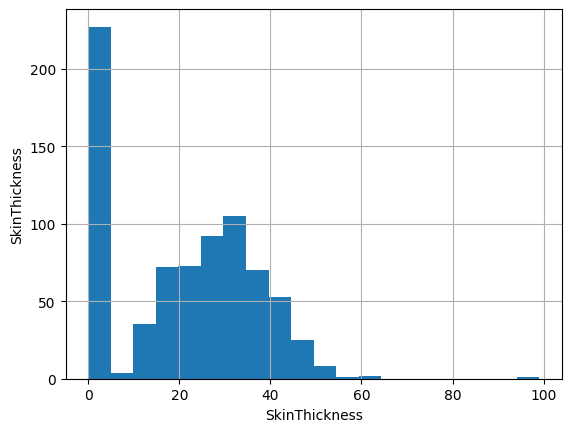

################### Insulin ###################
count   768.0000
mean     79.7995
std     115.2440
min       0.0000
1%        0.0000
5%        0.0000
10%       0.0000
20%       0.0000
30%       0.0000
40%       0.0000
50%      30.5000
60%      72.2000
70%     106.0000
80%     150.0000
90%     210.0000
95%     293.0000
99%     519.9000
100%    846.0000
max     846.0000
Name: Insulin, dtype: float64


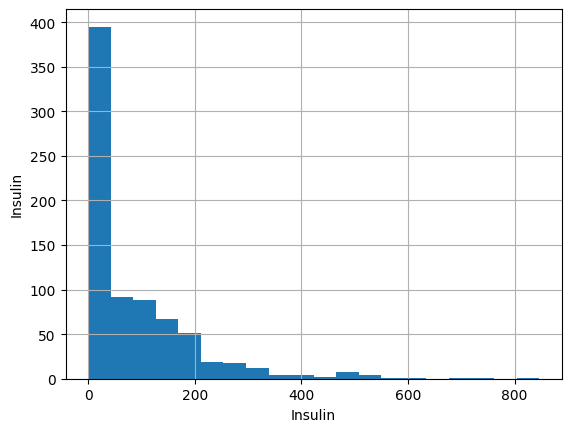

################### BMI ###################
count   768.0000
mean     31.9926
std       7.8842
min       0.0000
1%        0.0000
5%       21.8000
10%      23.6000
20%      25.9000
30%      28.2000
40%      30.1000
50%      32.0000
60%      33.7000
70%      35.4900
80%      37.8000
90%      41.5000
95%      44.3950
99%      50.7590
100%     67.1000
max      67.1000
Name: BMI, dtype: float64


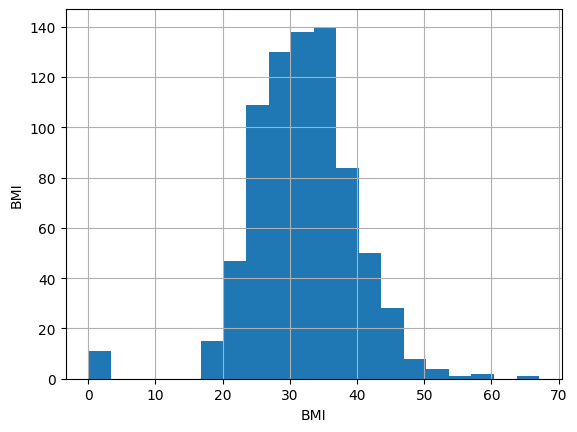

################### DiabetesPedigreeFunction ###################
count   768.0000
mean      0.4719
std       0.3313
min       0.0780
1%        0.0947
5%        0.1404
10%       0.1650
20%       0.2194
30%       0.2590
40%       0.3028
50%       0.3725
60%       0.4542
70%       0.5637
80%       0.6870
90%       0.8786
95%       1.1328
99%       1.6983
100%      2.4200
max       2.4200
Name: DiabetesPedigreeFunction, dtype: float64


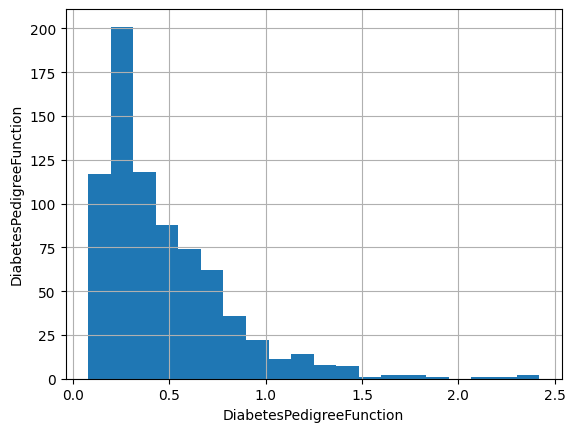

################### Age ###################
count   768.0000
mean     33.2409
std      11.7602
min      21.0000
1%       21.0000
5%       21.0000
10%      22.0000
20%      23.0000
30%      25.0000
40%      27.0000
50%      29.0000
60%      33.0000
70%      38.0000
80%      42.6000
90%      51.0000
95%      58.0000
99%      67.0000
100%     81.0000
max      81.0000
Name: Age, dtype: float64


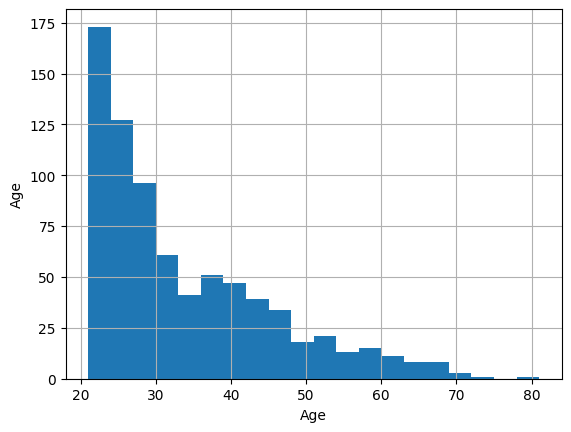

In [14]:
num_summary_df(df)

In [17]:
def plot_num_summary(dataframe):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_cols_names(dataframe)
  plt.figure(figsize=(10,4))
  for index, col in enumerate(num_cols):
    plt.subplot(2, 4, index+1)
    plt.tight_layout()
    dataframe[col].hist(bins=20)
    plt.title(col)

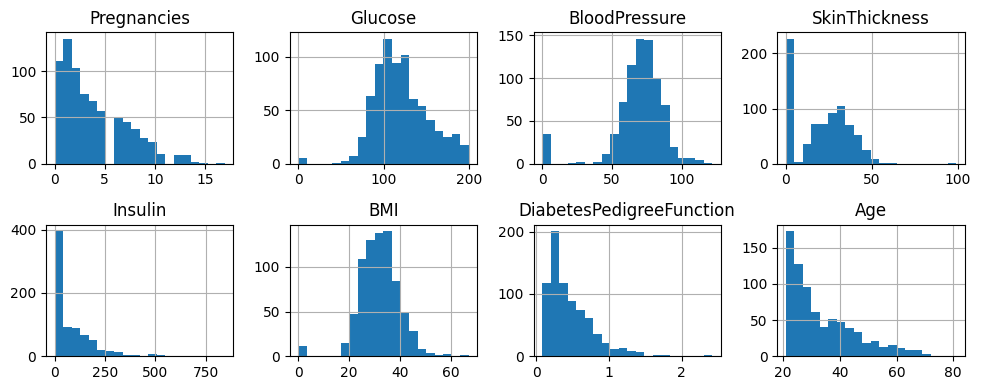

In [18]:
plot_num_summary(df)

In [20]:
def target_summary_with_cat(dataframe, target, categorical_col):
  print(f"################### {target} -> {categorical_col} ###################")
  print(pd.DataFrame({"Target Mean": dataframe.groupby(categorical_col)[target].mean()}))

In [21]:
def target_summary_with_cat_df(dataframe, target):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_cols_names(dataframe)
  for col in cat_cols:
    target_summary_with_cat(dataframe, target, col)

In [23]:
target_summary_with_cat_df(df, "Outcome")

################### Outcome -> Outcome ###################
         Target Mean
Outcome             
0             0.0000
1             1.0000


In [24]:
def target_summary_with_num(dataframe, target, numerical_col):
  print(f"#################### {target} -> {numerical_col} ####################")
  print(pd.DataFrame({"Target Mean": dataframe.groupby(target)[numerical_col].mean()}))

In [25]:
def target_summary_with_num_df(dataframe, target):
  cat_cols, num_cols, cat_but_car, num_but_cat = grab_cols_names(dataframe)
  for col in num_cols:
    target_summary_with_num(dataframe, target, col)

In [26]:
target_summary_with_num_df(df, "Outcome")

#################### Outcome -> Pregnancies ####################
         Target Mean
Outcome             
0             3.2980
1             4.8657
#################### Outcome -> Glucose ####################
         Target Mean
Outcome             
0           109.9800
1           141.2575
#################### Outcome -> BloodPressure ####################
         Target Mean
Outcome             
0            68.1840
1            70.8246
#################### Outcome -> SkinThickness ####################
         Target Mean
Outcome             
0            19.6640
1            22.1642
#################### Outcome -> Insulin ####################
         Target Mean
Outcome             
0            68.7920
1           100.3358
#################### Outcome -> BMI ####################
         Target Mean
Outcome             
0            30.3042
1            35.1425
#################### Outcome -> DiabetesPedigreeFunction ####################
         Target Mean
Outcome            

# Korelasyon Analizi

In [27]:
def high_correlated_cols(dataframe, corr_th = 0.90, plot=False):
  numeric_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["uint8", "int64", "float64"]]
  corr_matrix = dataframe[numeric_cols].corr()
  corr_matrix = corr_matrix.abs()
  upper_triangle_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
  drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

  if drop_list == []:
    print("############ After Correlation Analysis, You Don't Need to Remove Variables ############")

  if plot:
    sns.set(rc={'figure.figsize': (6, 3)})
    sns.heatmap(corr_matrix, cmap="RdBu", annot=True, fmt=".2f")
    plt.show()

  return drop_list

############ After Correlation Analysis, You Don't Need to Remove Variables ############


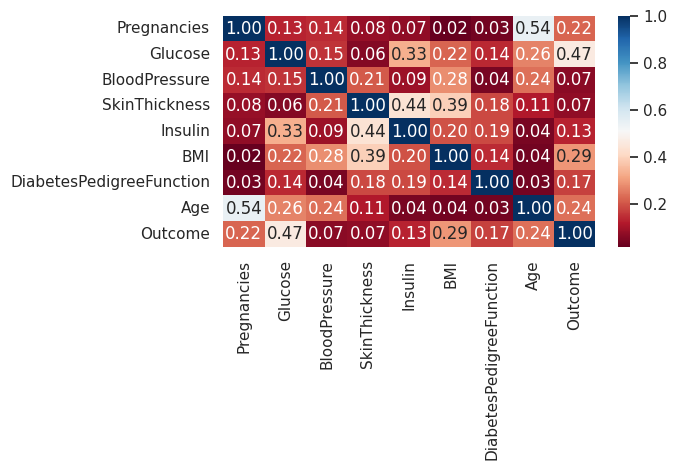

[]

In [28]:
high_correlated_cols(df, plot=True)

In [29]:
def high_correlated_df_remove(dataframe):
  drop_list = high_correlated_cols(dataframe)
  new_df = dataframe.drop(drop_list, axis=1)
  sns.set(rc={'figure.figsize': (6,3)})
  sns.heatmap(new_df.corr(), cmap="RdBu", annot=True, fmt=".2f")
  plt.show()

############ After Correlation Analysis, You Don't Need to Remove Variables ############


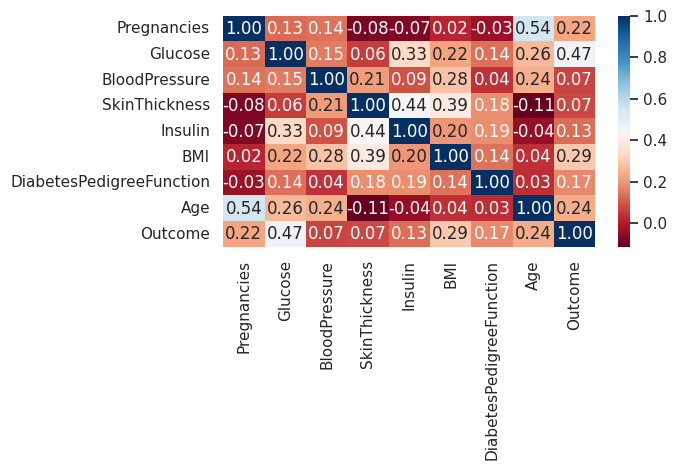

In [30]:
high_correlated_df_remove(df)